# Quantum plots (beta)

This notebook provides plotting functionality tailored for the use with the `quantumarticle` documentclass.

### IMPORTANT

In case this notebook does not run smoothly, please open an Issue on our GitHub page https://github.com/quantum-journal/quantum-journal/issues and append the following information:

- The error message (you can include the whole output as .html).
- The version of Jupyter notebook and IPython (as found in the menu under Help > About).
- The version of Matplotlib and the current backend. This information can be found by running the following code:
    ```python
    print(mpl.__version__)
    print(mpl.get_backend())
    ```
    
You will help us tremendously in improving your experience.

Should you have the problem that your figures are not displayed in the Jupyter notebook, you can still save them as PDF documents via `plt.savefig('filename.pdf')`. Afterwards you can use your favorite PDF viewer to check your figures. Nevertheless you should inform us so that the bug can be removed.

## Global routines

The parameters for the plots are set in a way that the font sizes in the resulting graphic match those in the surrounding document.

In [2]:
import pickle
import xarray
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib import rc
from cycler import cycler
from scipy.optimize import curve_fit
from atommover.utils.core import PhysicalParams
import matplotlib.colors as mcolors
from scipy.ndimage import zoom, gaussian_filter

_widths = {
    # a4paper columnwidth = 426.79135 pt = 5.93 in
    # letterpaper columnwidth = 443.57848 pt = 6.16 in
    'onecolumn': {
        'a4paper' : 5.93,
        'letterpaper' : 6.16
    },
    # a4paper columnwidth = 231.84843 pt = 3.22 in
    # letterpaper columnwidth = 240.24199 pt = 3.34 in
    'twocolumn': {
        'a4paper' : 3.22,
        'letterpaper' : 3.34
    }
}

_wide_widths = {
    # a4paper wide columnwidth = 426.79135 pt = 5.93 in
    # letterpaper wide columnwidth = 443.57848 pt = 6.16 in
    'onecolumn': {
        'a4paper' : 5.93,
        'letterpaper' : 6.16
    },
    # a4paper wide linewidth = 483.69687 pt = 6.72 in
    # letterpaper wide linewidth = 500.48400 pt = 6.95 in
    'twocolumn': {
        'a4paper' : 6.72,
        'letterpaper' : 6.95
    }
}

_fontsizes = {
    10 : {
        'tiny' : 5,
        'scriptsize' : 7,
        'footnotesize' : 8, 
        'small' : 9, 
        'normalsize' : 10,
        'large' : 12, 
        'Large' : 14, 
        'LARGE' : 17,
        'huge' : 20,
        'Huge' : 25
    },
    11 : {
        'tiny' : 6,
        'scriptsize' : 8,
        'footnotesize' : 9, 
        'small' : 10, 
        'normalsize' : 11,
        'large' : 12, 
        'Large' : 14, 
        'LARGE' : 17,
        'huge' :  20,
        'Huge' :  25
    },
    12 : {
        'tiny' : 6,
        'scriptsize' : 8,
        'footnotesize' : 10, 
        'small' : 11, 
        'normalsize' : 12,
        'large' : 14, 
        'Large' : 17, 
        'LARGE' : 20,
        'huge' :  25,
        'Huge' :  25
    }
}

_width         = 1
_wide_width    = 1
_nikhilgreen = [0.2,0.8,0.5]
_nikhilblue = [0.5,0.7,1]
_nikhilorange = [1,0.5,0.2]
_quantumviolet = '#53257F'
_quantumgray   = '#555555'

# Sets up the plot with the fitting arguments so that the font sizes of the plot
# and the font sizes of the document are well aligned
#
#     columns : string = ('onecolumn' | 'twocolumn')
#         the columns you used to set up your quantumarticle, 
#         defaults to 'twocolumn'
#
#     paper : string = ('a4paper' | 'letterpaper')
#         the paper size you used to set up your quantumarticle,
#         defaults to 'a4paper'
#
#     fontsize : int = (10 | 11 | 12)
#         the fontsize you used to set up your quantumarticle as int
#
#     (returns) : dict
#         parameters that can be used for plot adjustments

def global_setup(columns = 'twocolumn', paper = 'a4paper', fontsize = 10):
    plt.rcdefaults()
        
    # Seaborn white is a good base style
    plt.style.use(['seaborn-v0_8-whitegrid', './quantum-plots.mplstyle'])
    
    try:        
        # This hackery is necessary so that jupyther shows the plots
        mpl.use("pgf")
        %matplotlib inline
        plt.plot()
        mpl.use("pgf")
    except:
        print('Call to matplotlib.use had no effect')
        
    mpl.interactive(False) 
    
    # Now prepare the styling that depends on the settings of the document
    
    global _width 
    _width = _widths[columns][paper]
    
    global _wide_width 
    _wide_width = _wide_widths[columns][paper]
    
    # Use the default fontsize scaling of LaTeX
    global _fontsizes
    fontsizes = _fontsizes[fontsize]
    
    plt.rcParams['axes.labelsize'] = fontsizes['small']
    plt.rcParams['axes.titlesize'] = fontsizes['large']
    plt.rcParams['xtick.labelsize'] = fontsizes['footnotesize']
    plt.rcParams['ytick.labelsize'] = fontsizes['footnotesize']
    plt.rcParams['font.size'] = fontsizes['small']
    # mpl.rcParams['xtick.major.size'] = 20
    plt.rcParams['xtick.major.width'] = 0.5
    # mpl.rcParams['xtick.minor.size'] = 10
    plt.rcParams['xtick.minor.width'] = 0.5
    plt.rcParams['ytick.major.width'] = 0.5
    # mpl.rcParams['xtick.minor.size'] = 10
    plt.rcParams['ytick.minor.width'] = 0.5

    return {
            'fontsizes' : fontsizes,
            'colors' : {
                'quantumviolet' : _quantumviolet,
                'quantumgray' : _quantumgray,
                'nikhilgreen' : _nikhilgreen,
                'nikhilorange' : _nikhilorange,
                'nikhilblue' : _nikhilblue
            }
        }
    

# Sets up the plot with the fitting arguments so that the font sizes of the plot
# and the font sizes of the document are well aligned
#
#     aspect_ratio : float
#         the aspect ratio (width/height) of your plot
#         defaults to the golden ratio
#
#     width_ratio : float in [0, 1]
#         the width of your plot when you insert it into the document, e.g.
#         .8 of the regular width
#         defaults to 1.0
#
#     wide : bool 
#         indicates if the figures spans two columns in twocolumn mode, i.e.
#         when the figure* environment is used, has no effect in onecolumn mode 
#         defaults to False
#
#     (returns) : matplotlib figure object
#         the initialized figure object

def plot_setup(aspect_ratio = 1/1.62, width_ratio = 1.0, wide = False):
    width = (_wide_width if wide else _width) * width_ratio
    height = width * aspect_ratio
           
    return plt.figure(figsize=(width,height), dpi=120, facecolor='white')
    
print('Setup methods loaded')

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/nikhilharle/Desktop/Research/Bernien Lab/atom_rearrangement_project_2024/atommover/utils/animation.py:375: SyntaxWarning: invalid escape sequence '\i'
  """


Setup methods loaded


## Examples

When setting up your plots you have to call `global_setup` once and set the global options of your `quantumarticle`. 

The routine `global_setup` returns a dictionary with fontsizes and custom colors that should be used instead of numeric values. This ensures consistency with the other font sizes used in your LaTeX document. This means 
```python
fontsize = props['fontsizes']['large']
```
should be preferred over
```python
fontsize = 12
``` 

In [2]:
props = global_setup(columns = 'twocolumn', paper = 'a4paper', fontsize = 10)

print('Global props:')
for key in props:
    print(key, ':')
    for subkey in props[key]:
        print('    ', subkey, ': ', props[key][subkey])

Global props:
fontsizes :
     tiny :  5
     scriptsize :  7
     footnotesize :  8
     small :  9
     normalsize :  10
     large :  12
     Large :  14
     LARGE :  17
     huge :  20
     Huge :  25
colors :
     quantumviolet :  #53257F
     quantumgray :  #555555
     nikhilgreen :  [0.2, 0.8, 0.5]
     nikhilorange :  [1, 0.5, 0.2]
     nikhilblue :  [0.5, 0.7, 1]


/var/folders/37/82xwpt7x0sxf_stp0ldm5blr0000gp/T/ipykernel_27010/3115199435.py:121: MatplotlibDeprecationWarning: Auto-close()ing of figures upon backend switching is deprecated since 3.8 and will be removed two minor releases later.  To suppress this warning, explicitly call plt.close('all') first.
  mpl.use("pgf")


### Plotting advice

Plots should _always_ be saved as __PDF__ files via `plt.savefig('filename.pdf')`. This will result in the highest quality graphics that can seamlessly integrated in your publications. 

We further recommend that you use `tight_layout()` on your plots.

### Lineplot

To set up the plotting environment for your figure, you have to use the function `plot_setup` which ensures the proper sizing of your plot.

### Fig 2

In [22]:
# for Fig 2a
with open('data/fig2a_250123.pkl', 'rb') as file: 
    results_fig2a = pickle.load(file)

start_ind = 1
s_10 = results_fig2a['success rate'].to_numpy()[0,0,start_ind:,0,0,0]
s_100 = results_fig2a['success rate'].to_numpy()[0,0,start_ind:,1,0,0]
s_1000 = results_fig2a['success rate'].to_numpy()[0,0,start_ind:,2,0,0]
s_10000 = results_fig2a['success rate'].to_numpy()[0,0,start_ind:,3,0,0]

n_atoms = results_fig2a['n targets'].to_numpy()[0,0,:,0,0,0]
target_sizes = []
for i in range(start_ind, len(n_atoms)):
    target_size = n_atoms[i][0]
    target_sizes.append(target_size)

# for Fig 2b

with open('data/fig2b_250127.pkl', 'rb') as file: 
    results_fig2b = pickle.load(file)

r1 = results_fig2b['filling fraction'].to_numpy()[0,0,0,0,0,0]
r2 = results_fig2b['filling fraction'].to_numpy()[0,0,0,0,0,1]
r3 = results_fig2b['filling fraction'].to_numpy()[0,0,0,0,0,2]
s = results_fig2b['success rate'].to_numpy()[0,0,0,0,0,:]

fig = plot_setup(aspect_ratio = 0.4, width_ratio=2)
ax1 = plt.subplot2grid((1,30), (0,0), colspan=13)
ax2 = plt.subplot2grid((1,30), (0,15), colspan = 13)

# useful functions
def sigmoid(x,a,b):
    return 1/(1+np.exp(b*(x-a)))
def logfunc(x,a,b,c):
    return c*np.log(a*(x-b))
def pwlaw(x,a,b,c):
    return c*((x-a)**b)

## fig 2a ##
xdata = target_sizes

alpha_marker = 0.4
alpha_border = 0.7
colors = [_nikhilgreen, _quantumgray, _nikhilblue, _quantumviolet]
facecolors = colors

shapemarkers = ["v", "o", "s", "d"]
nummarkers = ['$10^{1}$', '$10^{2}$','$10^{3}$','$10^{4}$' ]
markers = shapemarkers
mark_size = 4
text_size = 7

edgecolors = colors
x_axis = np.linspace(1,6000, 100)

labels_full = [r'$t_{\text{lifetime}} = 10~\text{s}$', 
          r'$t_{\text{lifetime}} = 100~\text{s}$', 
          r'$t_{\text{lifetime}} = 1000~\text{s}$', 
          r'$t_{\text{lifetime}} = 10000~\text{s}$']
labels_num = ['10 s', '100 s', '1000 s', '10000 s']
labels_short = [r't=$10^{1}$ s', 
                r't=$10^{2}$ s', 
                r't=$10^{3}$ s', 
                r't=$10^{4}$ s']
labels = labels_short

# curve fits
popt10, pcov10 = curve_fit(sigmoid, xdata, s_10, p0 =[390,0.01])
ax1.plot(x_axis, sigmoid(x_axis, *popt10), c=colors[0])
perr10 = np.sqrt(np.diag(pcov10))

popt100, pcov100 = curve_fit(sigmoid, xdata, s_100, p0 =[1000,0.003])
ax1.plot(x_axis, sigmoid(x_axis, *popt100),c=colors[1])
perr100 = np.sqrt(np.diag(pcov100))

popt1000, pcov1000 = curve_fit(sigmoid, xdata, s_1000, p0 =[2000,0.001])
ax1.plot(x_axis, sigmoid(x_axis, *popt1000), c=colors[2])
perr1000 = np.sqrt(np.diag(pcov1000))

popt10000, pcov10000 = curve_fit(sigmoid, xdata, s_10000, p0 =[3900,0.001])
ax1.plot(x_axis, sigmoid(x_axis, *popt10000),c=colors[3])
perr10000 = np.sqrt(np.diag(pcov10000))


ymin, ymax = ax1.get_ylim() 
#vertical lines
ax1.vlines([popt10[0], popt100[0],popt1000[0]], colors=colors[:3], ymin = -5, ymax = 5, alpha = alpha_marker, linestyles='dashed')
ax1.vlines(popt10000[0], colors=colors[3], ymin = -5, ymax = 0.55, alpha = alpha_marker, linestyles='dashed')
ax1.set_ylim(ymin, ymax)
ax1.errorbar(target_sizes, s_10,    yerr=1/np.sqrt(1000)*s_10,    c=colors[0],label = labels[0], fmt = markers[0], markersize = mark_size, markerfacecolor=mpl.colors.to_rgba(facecolors[0], alpha=alpha_marker), markeredgecolor=mpl.colors.to_rgba(edgecolors[0], alpha=alpha_border))
ax1.errorbar(target_sizes, s_100,   yerr=1/np.sqrt(1000)*s_100,   c=colors[1],label = labels[1], fmt = markers[1], markersize = mark_size, markerfacecolor=mpl.colors.to_rgba(facecolors[1], alpha=alpha_marker), markeredgecolor=mpl.colors.to_rgba(edgecolors[1], alpha=alpha_border))
ax1.errorbar(target_sizes, s_1000,  yerr=1/np.sqrt(1000)*s_1000,  c=colors[2],label = labels[2], fmt = markers[2], markersize = mark_size, markerfacecolor=mpl.colors.to_rgba(facecolors[2], alpha=alpha_marker), markeredgecolor=mpl.colors.to_rgba(edgecolors[2], alpha=alpha_border))
ax1.errorbar(target_sizes, s_10000, yerr=1/np.sqrt(1000)*s_10000, c=colors[3],label = labels[3], fmt = markers[3], markersize = mark_size, markerfacecolor=mpl.colors.to_rgba(facecolors[3], alpha=alpha_marker), markeredgecolor=mpl.colors.to_rgba(edgecolors[3], alpha=alpha_border))


inset_ax = inset_axes(ax1, width="12%", height="24%", loc="upper right")  # Width and height as a percentage of main plot

lifetimes = np.array([10,100,1000,10000])
half_probs = [popt10[0], popt100[0],popt1000[0],popt10000[0]]

x_vals = np.linspace(0.005,10, 100)

popt, pcov = curve_fit(logfunc, lifetimes, half_probs, p0 =[0.01, 0, 1500], maxfev = 1000)

inset_ax.errorbar(lifetimes/1e3, 
             half_probs, 
             yerr = [perr10[0],perr100[0],perr1000[0],perr10000[0]],
             fmt = 'o', color=_nikhilblue)

inset_ax.plot(x_vals, logfunc(x_vals*1e3, *popt), color=_nikhilorange)
inset_fontsize = 7
inset_ax.set_ylabel('N [$10^{3}$]', fontsize = inset_fontsize)
inset_ax.set_xlabel(r't [$10^{3}$ s]',fontsize = inset_fontsize, labelpad = 1)
inset_ax.set_yticks([1000,2500,5000])
inset_ax.set_yticklabels([1,2.5,5],fontsize = inset_fontsize)
inset_ax.set_xticks([0,5,10])
inset_ax.set_xticklabels([0,5,10],fontsize = inset_fontsize)

ax1.legend(loc = 'lower right', prop={'size': 7})
ax1.set_ylabel("Success rate", fontsize=text_size)
ax1.set_xlabel("Number of atoms", fontsize=text_size)

## Fig 2b ##

bins = np.linspace(85, 100, 20)
data = np.zeros([len(r3), 2])
data[:,0] = 100*np.array(r3)
data[:,1] = 100*np.array(r1)
labels = ['3 rounds','1 round']
linestyles = ['-','--']
edgecolors = ["white", "gray"]
fillcolors = [_nikhilblue, _nikhilorange]
ab_size = 15 # size of a and b labels in combined figure

ax2.hist(100*np.array(r3), bins=bins,label=f'3 rounds', alpha = 0.6, color = fillcolors[0])
ax2.hist(100*np.array(r1), bins=bins,label=f'1 round', alpha = 0.6, color = fillcolors[1])
ax2.set_xlabel("Filling fraction [%]", fontsize=text_size)
ax2.set_ylabel("Counts", fontsize=text_size)
ax2.set_yscale('log')
ax2.set_xticks([85,90,95,100])
ax2.set_xticklabels([85,90,95,100], fontsize=text_size)
ax2.legend(prop={'size': 7})

# plt.gcf().text(0.02, 0.9, r'$\text{a}$', fontsize=ab_size)
# plt.gcf().text(0.52, 0.9, r'$\text{b}$', fontsize=ab_size)
plt.subplots_adjust(bottom=0.15, right = 0.97, left = 0.1)
plt.savefig('data/fig2_v2.pdf')

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [41]:
# getting data
# for Fig 2b

with open('data/fig2b_250127.pkl', 'rb') as file: 
      
    # A new file will be created 
    results_a = pickle.load(file)

r1 =results_a['filling fraction'].to_numpy()[0,0,0,0,0,0]
r2 =results_a['filling fraction'].to_numpy()[0,0,0,0,0,1]
r3 =results_a['filling fraction'].to_numpy()[0,0,0,0,0,2]
s = results_a['success rate'].to_numpy()[0,0,0,0,0,:]

# for Fig 2a
with open('data/fig2a_250123.pkl', 'rb') as file: 
      
    # A new file will be created 
    results_b = pickle.load(file)

start_ind = 1
s_10 = results_b['success rate'].to_numpy()[0,0,start_ind:,0,0,0]
s_100 = results_b['success rate'].to_numpy()[0,0,start_ind:,1,0,0]
s_1000 = results_b['success rate'].to_numpy()[0,0,start_ind:,2,0,0]
s_10000 = results_b['success rate'].to_numpy()[0,0,start_ind:,3,0,0]

n_atoms = results_b['n targets'].to_numpy()[0,0,:,0,0,0]
target_sizes = []
for i in range(start_ind, len(n_atoms)):
    target_size = n_atoms[i][0]
    target_sizes.append(target_size)

In [42]:
# initialize plotting object

fig = plot_setup(aspect_ratio = 0.45, width_ratio=1)

ax1 = plt.subplot2grid((1,26), (0,0), colspan=12)
ax2 = plt.subplot2grid((1,26), (0,14), colspan = 12)

In [11]:
def sigmoid(x,a,b):
    return 1/(1+np.exp(b*(x-a)))
xdata = target_sizes

alpha_marker = 0.4
alpha_border = 0.7
colors = [_nikhilgreen, _quantumgray, _nikhilblue, _quantumviolet] #['orange', '#555555', 'b', '#008080']
facecolors = colors


shapemarkers = ["v", "o", "s", "d"]
nummarkers = ['$10^{1}$', '$10^{2}$','$10^{3}$','$10^{4}$' ]
markers = shapemarkers
mark_size = 4

edgecolors = colors
x_axis = np.linspace(1,6000, 100)

labels_full = [r'$t_{\text{lifetime}} = 10~\text{s}$', 
          r'$t_{\text{lifetime}} = 100~\text{s}$', 
          r'$t_{\text{lifetime}} = 1000~\text{s}$', 
          r'$t_{\text{lifetime}} = 10000~\text{s}$']
labels_num = ['10 s', '100 s', '1000 s', '10000 s']
labels_short = [r't=$10^{1}$ s', 
                r't=$10^{2}$ s', 
                r't=$10^{3}$ s', 
                r't=$10^{4}$ s']
labels = labels_short


# curve fits
popt10, pcov10 = curve_fit(sigmoid, xdata, s_10, p0 =[390,0.01])#sigma=s_10*1/np.sqrt(1000), absolute_sigma=True)
ax1.plot(x_axis, sigmoid(x_axis, *popt10), c=colors[0])#,label=r'fit: a, b=%5.3f, %5.3f' % tuple(popt10))
perr10 = np.sqrt(np.diag(pcov10))

popt100, pcov100 = curve_fit(sigmoid, xdata, s_100, p0 =[1000,0.003])#, sigma=s_100*1/np.sqrt(1000), absolute_sigma=True)
ax1.plot(x_axis, sigmoid(x_axis, *popt100),c=colors[1])#,label=r'fit: a, b=%5.3f, %5.3f' % tuple(popt100))
perr100 = np.sqrt(np.diag(pcov100))

popt1000, pcov1000 = curve_fit(sigmoid, xdata, s_1000, p0 =[2000,0.001])#, sigma=s_1000*1/np.sqrt(1000), absolute_sigma=True)
ax1.plot(x_axis, sigmoid(x_axis, *popt1000), c=colors[2])#,label=r'fit: a, b=%5.3f, %5.3f' % tuple(popt1000))
perr1000 = np.sqrt(np.diag(pcov1000))

popt10000, pcov10000 = curve_fit(sigmoid, xdata, s_10000, p0 =[3900,0.001])#, sigma=s_10000*1/np.sqrt(1000), absolute_sigma=True)
ax1.plot(x_axis, sigmoid(x_axis, *popt10000),c=colors[3])#,label=r'fit: a, b=%5.3f, %5.3f' % tuple(popt10000))
perr10000 = np.sqrt(np.diag(pcov10000))


ymin, ymax = ax1.get_ylim()
# vertical lines
ax1.vlines([popt10[0], popt100[0],popt1000[0]], colors=colors[:3], ymin = -5, ymax = 5, alpha = alpha_marker, linestyles='dashed')
ax1.vlines(popt10000[0], colors=colors[3], ymin = -5, ymax = 0.55, alpha = alpha_marker, linestyles='dashed')

ax1.set_ylim(ymin, ymax)

ax1.errorbar(target_sizes, s_10,    yerr=1/np.sqrt(1000)*s_10,    c=colors[0],label = labels[0], fmt = markers[0], markersize = mark_size, markerfacecolor=mpl.colors.to_rgba(facecolors[0], alpha=alpha_marker), markeredgecolor=mpl.colors.to_rgba(edgecolors[0], alpha=alpha_border))
ax1.errorbar(target_sizes, s_100,   yerr=1/np.sqrt(1000)*s_100,   c=colors[1],label = labels[1], fmt = markers[1], markersize = mark_size, markerfacecolor=mpl.colors.to_rgba(facecolors[1], alpha=alpha_marker), markeredgecolor=mpl.colors.to_rgba(edgecolors[1], alpha=alpha_border))
ax1.errorbar(target_sizes, s_1000,  yerr=1/np.sqrt(1000)*s_1000,  c=colors[2],label = labels[2], fmt = markers[2], markersize = mark_size, markerfacecolor=mpl.colors.to_rgba(facecolors[2], alpha=alpha_marker), markeredgecolor=mpl.colors.to_rgba(edgecolors[2], alpha=alpha_border))
ax1.errorbar(target_sizes, s_10000, yerr=1/np.sqrt(1000)*s_10000, c=colors[3],label = labels[3], fmt = markers[3], markersize = mark_size, markerfacecolor=mpl.colors.to_rgba(facecolors[3], alpha=alpha_marker), markeredgecolor=mpl.colors.to_rgba(edgecolors[3], alpha=alpha_border))


inset_ax = inset_axes(ax1, width="12%", height="24%", loc="upper right")  # Width and height as a percentage of main plot

def logfunc(x,a,b,c):
    return c*np.log(a*(x-b))
def pwlaw(x,a,b,c):
    return c*((x-a)**b)

lifetimes = np.array([10,100,1000,10000])
half_probs = [popt10[0], popt100[0],popt1000[0],popt10000[0]]

x_vals = np.linspace(0.005,10, 100)

popt, pcov = curve_fit(logfunc, lifetimes, half_probs, p0 =[0.01, 0, 1500], maxfev = 1000)
# pwpopt, pwpcov = curve_fit(pwlaw, lifetimes, half_probs, p0 =[0.01, 0.8, 2000], maxfev = 1000)

inset_ax.errorbar(lifetimes/1e3, 
             half_probs, 
             yerr = [perr10[0],perr100[0],perr1000[0],perr10000[0]],
             fmt = 'o', color=_nikhilblue)

inset_ax.plot(x_vals, logfunc(x_vals*1e3, *popt), color=_nikhilorange)
# plt.plot(x_vals, pwlaw(x_vals, *popt), label = 'pwlaw')
# print([perr10[0],perr100[0],perr1000[0],perr10000[0]])
inset_fontsize = props['fontsizes']['scriptsize']
inset_ax.set_ylabel('N/1000', fontsize = inset_fontsize)
inset_ax.set_xlabel(r't [$10^{3}$s]',fontsize = inset_fontsize, labelpad = 1)
inset_ax.set_yticks([1000,2500,5000])
inset_ax.set_yticklabels([1,2.5,5],fontsize = inset_fontsize)
inset_ax.set_xticks([0,5,10])
inset_ax.set_xticklabels([0,5,10],fontsize = inset_fontsize)

ax1.legend(loc = 'lower right', prop={'size': props['fontsizes']['scriptsize']})
# plt.title(r"Lifetime-limited performance")
ax1.set_ylabel("Success rate")
ax1.set_xlabel("Number of atoms")
# plt.savefig('figs/2a.svg')
# plt.tight_layout()
# plt.savefig('data/fig2a.pdf')

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Text(0.5, 0, 'Number of atoms')

In [12]:
# Fig 2b
# r1 =results['filling fraction'].to_numpy()[0,0,0,0,0,0]
# r2 =results['filling fraction'].to_numpy()[0,0,0,0,0,1]
# r3 =results['filling fraction'].to_numpy()[0,0,0,0,0,2]
# s = results['success rate'].to_numpy()[0,0,0,0,0,:]

# fig = plot_setup()

bins = np.linspace(85, 100, 20)

data = np.zeros([len(r3), 2])
data[:,0] = 100*np.array(r3)
data[:,1] = 100*np.array(r1)
labels = ['3 rounds','1 round']
linestyles = ['-','--']
edgecolors = ["white", "gray"]
fillcolors = [_nikhilblue, _nikhilorange]

ax2.hist(100*np.array(r3), bins=bins,label=f'3 rounds', alpha = 0.6, color = fillcolors[0])#, linestyle=linestyles[0], edgecolor=edgecolors[0])
ax2.hist(100*np.array(r1), bins=bins,label=f'1 round', alpha = 0.6, color = fillcolors[1])#, linestyle=linestyles[1], edgecolor=edgecolors[1])
ax2.set_xlabel("Filling fraction [%]")
ax2.set_ylabel("Counts")
ax2.set_yscale('log')
ax2.set_xticks([85,90,95,100])
ax2.set_xticklabels([85,90,95,100])
ax2.legend(prop={'size': props['fontsizes']['scriptsize']})
# fig.subplots_adjust(bottom=0.2)
# plt.savefig('data/fig2b.svg')
absize = props['fontsizes']['Large']
plt.gcf().text(0.02, 0.9, r'\textbf{a}', fontsize=absize)
plt.gcf().text(0.52, 0.9, r'\textbf{b}', fontsize=absize)
plt.subplots_adjust(bottom=0.15, right = 0.97, left = 0.1)
plt.savefig('data/fig2.svg')

In [8]:
plt.savefig('data/fig2b.pdf')

### Fig 3

In [19]:
# getting data

with open('data/scaling_250203.pkl', 'rb') as file: 
    results = pickle.load(file)

with open('data/scaling_zstareucl_250204.pkl', 'rb') as file: 
    euclidean_array = pickle.load(file)

with open('data/scaling_zstargrid_250204.pkl', 'rb') as file: 
    grid_array = pickle.load(file)

with open('data/scaling_parallel_250206.pkl', 'rb') as file: 
    # A new file will be created
    parresults = pickle.load(file)

with open('data/scaling_bcnew_250605.pkl', 'rb') as file: 
    bcnew_res = pickle.load(file)

hun = results['time'].to_numpy()[0,0,:,0,0,0]*1e3
bc = bcnew_res['time'].to_numpy()[0,0,:,0,0,0]*1e3
targets = results['n targets'].to_numpy()[0,0,:,0,0,0]
n_atoms = []
for tnum in targets:
    n_atoms.append(tnum[0])

params = PhysicalParams()
l6_eucl = np.mean(euclidean_array[2,:,:], axis=1)*(params.spacing/(params.AOD_speed))*1e3 # ms
l6_grid = np.mean(grid_array[2,:,:], axis=1)*(params.spacing/(params.AOD_speed))*1e3 # ms
l6_eucl_std = np.std(euclidean_array[2,:,:], axis=1)*(params.spacing/(params.AOD_speed))*1e3 # ms
l6_grid_std = np.std(grid_array[2,:,:], axis=1)*(params.spacing/(params.AOD_speed))*1e3 # ms

parhun = parresults['time'].to_numpy()[0,0,:,0,0,0]*1e3
parLBAP = parresults['time'].to_numpy()[1,0,:,0,0,0]*1e3
hun2 = parresults['time'].to_numpy()[2,0,:,0,0,0]*1e3

In [20]:
# initialize plotting object

fig = plot_setup(aspect_ratio = 0.85, width_ratio=0.9)

ax1 = plt.subplot2grid((1,1), (0,0))
# ax2 = plt.subplot2grid((1,17), (0,8), colspan=8)

In [21]:
# plot params
alpha_marker = 0.4
alpha_border = 0.7
colors = [_nikhilgreen, _quantumgray, _nikhilblue, _quantumviolet, _nikhilorange, [0.4, 0.2, 0.7]] #['orange', '#555555', 'b', '#008080']
facecolors = colors

shapemarkers = ["v", "s", "o", "d", '^', "P"]
markers = shapemarkers
mark_size = 4

edgecolors = colors
x_axis = np.linspace(np.min(n_atoms), np.max(n_atoms), 100)

labels_full = ['Hungarian', 
               'BalCompact', 
               r'Z$*$', 
               r'Z$*$ (grid)', 
               'ParHungarian', 
               'ParLBAP']
labels = labels_full

def pwlaw(x,b,c):
    return c*((x)**b)


poptparh, pcovparh = curve_fit(pwlaw, n_atoms, parhun, p0 =[1.1, 0.01], maxfev = 100000)
perrparh = np.sqrt(np.diag(pcovparh))
poptLBAP, pcovLBAP = curve_fit(pwlaw, n_atoms, parLBAP, p0 =[1.6, 0.1], maxfev = 100000)
perrLBAP = np.sqrt(np.diag(pcovLBAP))

poptbc, pcovbc = curve_fit(pwlaw, n_atoms, bc, p0 =[1,0.01], maxfev = 100000)
perrbc = np.sqrt(np.diag(pcovbc))
popthun, pcovhun = curve_fit(pwlaw, n_atoms, hun, p0 =[1.6,0.1], maxfev = 100000)
perrhun = np.sqrt(np.diag(pcovhun))

popt_euc, pcov_euc = curve_fit(pwlaw, n_atoms, l6_eucl, sigma = l6_eucl_std,absolute_sigma=True,p0 =[1,0.01], maxfev = 100000)
perr_euc = np.sqrt(np.diag(pcov_euc))
popt_gr, pcov_gr = curve_fit(pwlaw, n_atoms, l6_grid, sigma=l6_grid_std, absolute_sigma=True, p0 =[1.6,0.1], maxfev = 100000)
perr_gr = np.sqrt(np.diag(pcov_gr))

ax1.plot(x_axis, pwlaw(x_axis, *popthun),c=colors[0])
ax1.plot(x_axis, pwlaw(x_axis, *poptbc),c=colors[1])
ax1.plot(x_axis, pwlaw(x_axis, *popt_gr),c=colors[3])
ax1.plot(x_axis, pwlaw(x_axis, *popt_euc),c=colors[2])
ax1.plot(x_axis, pwlaw(x_axis, *poptparh),c=colors[4])
# ax1.plot(x_axis, pwlaw(x_axis, *poptLBAP),c=colors[5])


ax1.errorbar(n_atoms, hun,     yerr=1/np.sqrt(100)*hun,     c=colors[0],label = labels[0], fmt = markers[0], markersize = mark_size, markerfacecolor=mpl.colors.to_rgba(facecolors[0], alpha=alpha_marker), markeredgecolor=mpl.colors.to_rgba(edgecolors[0], alpha=alpha_border))
ax1.errorbar(n_atoms, bc,      yerr=1/np.sqrt(100)*bc,      c=colors[1],label = labels[1], fmt = markers[1], markersize = mark_size, markerfacecolor=mpl.colors.to_rgba(facecolors[1], alpha=alpha_marker), markeredgecolor=mpl.colors.to_rgba(edgecolors[1], alpha=alpha_border))
ax1.errorbar(n_atoms, parhun,  yerr=1/np.sqrt(100)*parhun,  c=colors[4],label = labels[4], fmt = markers[4], markersize = mark_size, markerfacecolor=mpl.colors.to_rgba(facecolors[4], alpha=alpha_marker), markeredgecolor=mpl.colors.to_rgba(edgecolors[4], alpha=alpha_border))
ax1.errorbar(n_atoms, l6_grid, yerr=1/np.sqrt(100)*l6_grid, c=colors[3],label = labels[3], fmt = markers[3], markersize = mark_size, markerfacecolor=mpl.colors.to_rgba(facecolors[3], alpha=alpha_marker), markeredgecolor=mpl.colors.to_rgba(edgecolors[3], alpha=alpha_border))
ax1.errorbar(n_atoms, l6_eucl, yerr=1/np.sqrt(100)*l6_eucl, c=colors[2],label = labels[2], fmt = markers[2], markersize = mark_size, markerfacecolor=mpl.colors.to_rgba(facecolors[2], alpha=alpha_marker), markeredgecolor=mpl.colors.to_rgba(edgecolors[2], alpha=alpha_border))
# ax1.errorbar(n_atoms, parLBAP, yerr=1/np.sqrt(100)*parLBAP, c=colors[5],label = labels[5], fmt = markers[5], markersize = mark_size, markerfacecolor=mpl.colors.to_rgba(facecolors[3], alpha=alpha_marker), markeredgecolor=mpl.colors.to_rgba(edgecolors[5], alpha=alpha_border))

# plt.scatter(n_atoms, parhun, label = 'ParallelHungarian')
text_size = props['fontsizes']['scriptsize']
ax1.legend(prop={'size': text_size})
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_xticks([100, 200, 500])
ax1.set_xticklabels([r'$10^{2}$', r'$2\times 10^{2}$', r'$5\times 10^{2}$'],fontsize = text_size)
ax1.set_ylabel('Rearrangement time [ms]')
ax1.set_xlabel('Number of atoms')

def deg2rad(x):
    return x / ((params.spacing/(params.AOD_speed))*1e3)

def rad2deg(x):
    return x*(params.spacing/(params.AOD_speed))*1e3


secax = ax1.secondary_yaxis('right', functions=(deg2rad, rad2deg))
secax.set_ylabel('Number of moves')
plt.subplots_adjust(bottom=0.15, right = 0.85, left = 0.15, top = 0.95)
plt.savefig('data/fig3a.pdf')

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [9]:
plt.savefig('data/fig3a.pdf')

In [40]:
print(f'Hungarian fit is {popthun}, {perrhun}')
print(f'BC fit is {poptbc}, {perrbc}')
print(f'Z* fit is {popt_euc}, {perr_euc}')
print(f'Z* grid fit is {popt_gr}, {perr_gr}')

Hungarian fit is [1.47046252 0.00666028], [0.01726514 0.00070234]
BC fit is [1.11682198 0.0177949 ], [0.14134466 0.01520828]
Z* fit is [0.48787907 0.02666921], [0.03996827 0.0062297 ]
Z* grid fit is [0.48149282 0.02805078], [0.03782874 0.00621916]


### Fig 5

In [10]:
with open('data/comparison_fig_250527.pkl', 'rb') as file: 
    results = pickle.load(file)

tweezer_errors = np.logspace(-4, -2.5, 30)[::-1]
vac_lifetimes = np.logspace(-1.2, 1, 30)

xlen = 34
ylen = 12
fig = plot_setup(aspect_ratio = 1.5, width_ratio=1)

# ax1 = plt.subplot2grid((ylen,xlen), (0,0), colspan = 14, rowspan=3)
# ax2 = plt.subplot2grid((ylen,xlen), (0,16), colspan = 17, rowspan=3)
# ax3 = plt.subplot2grid((ylen,xlen), (4,0), colspan = 36, rowspan=3)
# ax4 = plt.subplot2grid((ylen,xlen), (9,0), colspan = 30, rowspan=3)

outer_gs = gridspec.GridSpec(nrows=3, ncols=2, figure=fig, width_ratios=[30, 1], height_ratios=[0.9, 1, 1], hspace=0.5, wspace=0.1)

# First row: nested GridSpec for two plots
inner_gs = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=outer_gs[0, 0], wspace=0.3)

ax1 = fig.add_subplot(inner_gs[0, 0])
ax2 = fig.add_subplot(inner_gs[0, 1])
cax2 = fig.add_subplot(outer_gs[0, 1])  # Colorbar axis
# Second row: single plot
ax3 = fig.add_subplot(outer_gs[1, 0])
cax3 = fig.add_subplot(outer_gs[1, 1])

# Third row: single plot
ax4 = fig.add_subplot(outer_gs[2, 0])

text_size = 7 #props['fontsizes']['scriptsize']
successes = results['success rate'].to_numpy()

rates = results['success rate'].to_numpy()[1,0,0,:,0,0]

X, Y = np.meshgrid(np.array(tweezer_errors)*100, np.array(vac_lifetimes))
rates_arr = results['success rate'].to_numpy()[:,0,0,:,0,0]

cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", [_nikhilorange, 'white', _nikhilblue])
linecut_col = _nikhilgreen
tickpad = 1

for i in range(3):
    try:
        rates = rates_arr[i,:]
    except IndexError:
        rates = np.zeros_like(rates_arr[0,:]).reshape(len(vac_lifetimes), len(tweezer_errors))
        for mi in range(len(rates)):
            for mj in range(len(rates[0])):
                options = rates_arr[:,mi*len(tweezer_errors)+mj]
                rates[mi,mj] = options[0]/options[1]
    Z = rates.reshape(len(tweezer_errors),len(vac_lifetimes)).T
    if i == 2:
        vcenter = 1
        vmax = Z.max()
        Z_smooth = gaussian_filter(Z, sigma=1)
    else:
        vcenter = 0.5
        vmax = 1

    norm = mcolors.TwoSlopeNorm(vmin=0, vcenter=vcenter, vmax=vmax)
    
    if i == 2:
        im = ax3.pcolor(X,Y, Z, cmap=cmap, norm=norm)
        ax3.set_yscale('log')
        ax3.set_xscale('log')
        ax3.set_ylim([np.min(vac_lifetimes), np.max(vac_lifetimes)])
        # ax3.set_xlabel("Tweezer error (%)", fontsize=text_size)
        # Normalize so that 1 is at the center
        cbar = fig.colorbar(im, cax=cax3, cmap=cmap, norm=norm)
        ax3.axvline(tweezer_errors[16]*100, linestyle = 'dashdot', color = linecut_col, linewidth = 0.5)
        # ax3.set_title('Ratio', fontsize=text_size)
        ax3.set_xticks([1e-2, 1e-1])
        ax3.set_xticklabels([r'0.01', r'0.1'],fontsize = text_size)
        ax3.set_yticks([10,1,0.1])
        ax3.set_yticklabels([r'10',r'1', r'0.1'],fontsize = text_size)
        ax3.tick_params(direction = 'inout', pad=tickpad, axis='both')
        cbar.ax.set_ylabel('rH/rBC', fontsize=text_size, labelpad = 1.25)
        cbar.ax.tick_params(labelsize=text_size, direction = 'inout', axis='both', pad=tickpad)
        cbar.ax.set_yticks([2,1,0.5,0])
        cbar.ax.set_yticklabels([r'2',r'1',r'0.5', r'0'])
        con = ax3.contour(X,Y,Z_smooth, levels = [0.9, 1, 1.25], colors = 'k', linewidths = 0.5, linestyles = ['-', '--', ':'])
        ax3.clabel(con, fontsize=text_size)
        ax3.set_xlabel("Tweezer error [%]", fontsize=text_size)
    elif i==0:
        im = ax1.pcolor(X,Y, Z, cmap=cmap, norm=norm)
        ax1.set_yscale('log')
        ax1.set_xscale('log')
        ax1.set_ylim([np.min(vac_lifetimes), np.max(vac_lifetimes)])
        # ax1.set_xlabel("Tweezer error (%)", fontsize=text_size)
        ax1.set_ylabel("Lifetime [s]", fontsize=text_size)
        ax1.yaxis.set_label_coords(-0.5, -0.35, transform=None)
        ax1.set_title('Hun.', fontsize=text_size)
        ax1.set_xticks([1e-2, 1e-1])
        ax1.set_xticklabels([r'0.01', r'0.1'],fontsize = text_size)
        ax1.set_yticks([10,1,0.1])
        ax1.set_yticklabels([r'10',r'1', r'0.1'],fontsize = text_size)
        ax1.tick_params(direction = 'inout', axis='both', which='major', pad=tickpad)
    elif i==1:
        im = ax2.pcolor(X,Y, Z, cmap=cmap, norm=norm)
        ax2.set_yscale('log')
        ax2.set_xscale('log')
        ax2.set_ylim([np.min(vac_lifetimes), np.max(vac_lifetimes)])
        ax2.set_title('BC.', fontsize=text_size)
        ax2.set_xticks([1e-2, 1e-1])
        ax2.set_xticklabels([r'0.01', r'0.1'],fontsize = text_size)
        ax2.set_yticklabels([])
        cbar = fig.colorbar(im, cax=cax2)
        cbar.ax.tick_params(labelsize=text_size, direction = 'inout', pad=tickpad)
        cbar.ax.set_yticks([1,0.5,0])
        cbar.ax.set_yticklabels([r'1',r'0.5', r'0'])
        cbar.ax.set_ylabel(r'Success rate r', fontsize=text_size, labelpad = 1.5)
        ax2.tick_params(direction = 'inout', axis='both', pad=tickpad)

pointcolor = linecut_col
markersize = 3
ax4.errorbar(np.array(vac_lifetimes), rates[16,:], yerr=1/np.sqrt(1000)*rates[16,:], c=pointcolor,fmt = "v", markersize = markersize, markerfacecolor=mpl.colors.to_rgba(pointcolor, alpha=0.4), markeredgecolor=mpl.colors.to_rgba(pointcolor, alpha=0.7), elinewidth=0.5)
ax4.set_xscale('log')
ax4.hlines(1, xmin = min(vac_lifetimes)*0.8, xmax = max(vac_lifetimes)*1.25, color = 'k', ls = '--', linewidth = 0.5)
ax4.set_xlabel('Lifetime [s]', fontsize = text_size)
ax4.set_xticks([0.1, 1, 10])
ax4.set_xticklabels(['0.1', '1', '10'],fontsize = text_size)
# ax4.yaxis.tick_right()
# ax4.yaxis.set_label_position("right")
ax4.set_yticks([0.8, 0.9, 1, 1.1, 1.2])
ax4.set_yticklabels(['0.8','0.9', '1', '1.1','1.2'],fontsize = text_size)
ax4.set_ylabel('rH / rBC', fontsize = text_size)
ax4.tick_params(labelsize=text_size, pad=tickpad, direction='inout')
# ax4.set_ylabel(r'$r_{H} / r_{BC}$'

plt.subplots_adjust(bottom=0.12, right = 0.78, left = 0.22, top = 0.93)
plt.savefig('data/fig5.pdf')

### Fig 4

NameError: name 'props' is not defined

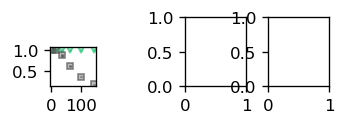

In [3]:
# importing data
df_c = pd.read_csv("data/Fig_4c_data_final.csv")
df_d_inout=pd.read_csv("data/Fig_4d_inside_out_Final.csv").iloc[:-1]
df_d_parh = pd.read_csv("data/Fig_4d_naive_par_Final.csv").iloc[:-1]
df_e_inout=pd.read_csv("data/Fig_4e_inside_out_Final.csv").iloc[:-1].iloc[12:]
df_e_parh = pd.read_csv("data/Fig_4e_naive_par_Final.csv").iloc[:-1].iloc[12:]

alpha_marker = 0.4
alpha_border = 0.7
colors = [_nikhilgreen, _quantumgray, _nikhilblue, _quantumviolet, _nikhilorange, [0.4, 0.2, 0.7]] #['orange', '#555555', 'b', '#008080']
facecolors = colors

shapemarkers = ["v", "s", "o", "d", '^', "P"]
markers = shapemarkers
mark_size = 4
labels_c = ['InOut', 'ParHun']
labels_d = ['Sufficient rate','Checker (InOut)', 'Zebra (InOut)', 'Zones (InOut)', 'Checker (ParHun)', 'Zebra (ParHun)', 'Zones (ParHun)']

edgecolors = colors

fig = plot_setup(aspect_ratio = 0.25, width_ratio=3)

# Outer GridSpec: 1 row × 4 columns
outer_gs = gridspec.GridSpec(1, 4, width_ratios=[0.75, 0.75, 1, 1], wspace=0.4)

# First column: Nested GridSpec (2 rows in col 0)
left_gs = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=outer_gs[0], height_ratios=[1, 1.5], hspace=0.1)
nextleft_gs = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=outer_gs[1], height_ratios=[1, 1.5], hspace=0.1)

# Top half of first column: further split into 2 side-by-side plots
# top_left_gs = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=left_gs[0], wspace=0.2)
# axA = fig.add_subplot(top_left_gs[0])
# axB = fig.add_subplot(top_left_gs[1])

# Bottom half of first column: single plot
axC = fig.add_subplot(left_gs[1])

# Columns 2–4: individual plots
axD = fig.add_subplot(outer_gs[2])
axE = fig.add_subplot(outer_gs[3])

n_atoms = []
for leng in df_c['System Size']:
    n_atoms.append(leng**2)

# fig 4c
axC.errorbar(n_atoms, df_c['Success Rate (Inside Out)'], yerr=df_c['Success Rate (Inside Out)']/np.sqrt(1000),c=colors[0],label = labels_c[0], fmt = markers[0], markersize = mark_size, markerfacecolor=mpl.colors.to_rgba(facecolors[0], alpha=alpha_marker), markeredgecolor=mpl.colors.to_rgba(edgecolors[0], alpha=alpha_border))
axC.errorbar(n_atoms, df_c['Success Rate (Naive)'], yerr=df_c['Success Rate (Naive)']/np.sqrt(1000),c=colors[1],label = labels_c[1], fmt = markers[1], markersize = mark_size, markerfacecolor=mpl.colors.to_rgba(facecolors[1], alpha=alpha_marker), markeredgecolor=mpl.colors.to_rgba(edgecolors[1], alpha=alpha_border))
text_size = props['fontsizes']['scriptsize']
axC.legend(prop={'size': text_size})
axC.set_ylim(0,1.05)
axC.set_yticks([0,0.25,0.5,0.75,1])
axC.set_ylabel('Success rate', fontsize=text_size)
axC.set_xlabel('Number of atoms', fontsize=text_size)

# fig 4d
load_probs = df_d_inout['LoadingProb']

# sufficient atom rate
axD.plot(load_probs, df_d_inout['Not_enough'], label = labels_d[0], ls='--', c = 'k',linewidth=0.5)
# inside out
axD.errorbar(load_probs, y=df_d_inout['Success_checker'], yerr=df_d_inout['Success_checker']/np.sqrt(1000), c=colors[0],label = labels_d[1], fmt = markers[0], markersize = mark_size, markerfacecolor=mpl.colors.to_rgba(facecolors[0], alpha=alpha_marker), markeredgecolor=mpl.colors.to_rgba(edgecolors[0], alpha=alpha_border))
axD.errorbar(load_probs, y=df_d_inout['Success_zebra'], yerr=df_d_inout['Success_zebra']/np.sqrt(1000), c=colors[1],label = labels_d[2], fmt = markers[0], markersize = mark_size, markerfacecolor=mpl.colors.to_rgba(facecolors[1], alpha=alpha_marker), markeredgecolor=mpl.colors.to_rgba(edgecolors[1], alpha=alpha_border))
axD.errorbar(load_probs, y=df_d_inout['Success_separate'], yerr=df_d_inout['Success_separate']/np.sqrt(1000), c=colors[2],label = labels_d[3], fmt = markers[0], markersize = mark_size, markerfacecolor=mpl.colors.to_rgba(facecolors[2], alpha=alpha_marker), markeredgecolor=mpl.colors.to_rgba(edgecolors[2], alpha=alpha_border))
# par hun
axD.errorbar(load_probs, y= df_d_parh['Success_checker'], yerr=df_d_parh['Success_checker']/np.sqrt(1000), c=colors[0],label = labels_d[4], fmt = markers[1], markersize = mark_size, markerfacecolor=mpl.colors.to_rgba(facecolors[0], alpha=alpha_marker), markeredgecolor=mpl.colors.to_rgba(edgecolors[0], alpha=alpha_border))
axD.errorbar(load_probs, y= df_d_parh['Success_zebra'],   yerr=df_d_parh['Success_zebra']/np.sqrt(1000), c=colors[1],label = labels_d[5], fmt = markers[1], markersize = mark_size, markerfacecolor=mpl.colors.to_rgba(facecolors[1], alpha=alpha_marker), markeredgecolor=mpl.colors.to_rgba(edgecolors[1], alpha=alpha_border))
axD.errorbar(load_probs, y= df_d_parh['Success_separate'],yerr=df_d_parh['Success_separate']/np.sqrt(1000), c=colors[2],label = labels_d[6], fmt = markers[1], markersize = mark_size, markerfacecolor=mpl.colors.to_rgba(facecolors[2], alpha=alpha_marker), markeredgecolor=mpl.colors.to_rgba(edgecolors[2], alpha=alpha_border))
axD.set_ylim(0,1.05)
axD.set_yticks([0,0.25,0.5,0.75,1])
axD.set_ylabel('Success rate', fontsize=text_size)
axD.set_xlabel('Loading probability [%]', fontsize=text_size)
# axD.legend(prop={'size': text_size})

# fig 4e
load_probs = df_e_inout['LoadingProb']
# inside out
axE.errorbar(load_probs, y=df_e_inout['MoveSteps_checker'], yerr=df_e_inout['MoveSteps_checker_std'], c=colors[0],label = labels_d[1], fmt = markers[0], markersize = mark_size, markerfacecolor=mpl.colors.to_rgba(facecolors[0], alpha=alpha_marker), markeredgecolor=mpl.colors.to_rgba(edgecolors[0], alpha=alpha_border))
axE.errorbar(load_probs, y=df_e_inout['MoveSteps_zebra'],   yerr=df_e_inout['MoveSteps_zebra_std'], c=colors[1],label = labels_d[2], fmt = markers[0], markersize = mark_size, markerfacecolor=mpl.colors.to_rgba(facecolors[1], alpha=alpha_marker), markeredgecolor=mpl.colors.to_rgba(edgecolors[1], alpha=alpha_border))
axE.errorbar(load_probs, y=df_e_inout['MoveSteps_separate'],yerr=df_e_inout['MoveSteps_separate_std'], c=colors[2],label = labels_d[3], fmt = markers[0], markersize = mark_size, markerfacecolor=mpl.colors.to_rgba(facecolors[2], alpha=alpha_marker), markeredgecolor=mpl.colors.to_rgba(edgecolors[2], alpha=alpha_border))
# par hun
axE.errorbar(load_probs, y= df_e_parh['MoveSteps_checker'],  yerr=df_e_parh['MoveSteps_checker']/np.sqrt(df_d_parh['Success_checker'].iloc[12:]*1000), c=colors[0],label = labels_d[4], fmt = markers[1], markersize = mark_size, markerfacecolor=mpl.colors.to_rgba(facecolors[0], alpha=alpha_marker), markeredgecolor=mpl.colors.to_rgba(edgecolors[0], alpha=alpha_border))
axE.errorbar(load_probs, y= df_e_parh['MoveSteps_zebra'],    yerr=df_e_parh['MoveSteps_zebra']/np.sqrt(df_d_parh['Success_zebra'].iloc[12:]*1000), c=colors[1],label = labels_d[5], fmt = markers[1], markersize = mark_size, markerfacecolor=mpl.colors.to_rgba(facecolors[1], alpha=alpha_marker), markeredgecolor=mpl.colors.to_rgba(edgecolors[1], alpha=alpha_border))
axE.errorbar(load_probs, y= df_e_parh['MoveSteps_separate'], yerr=df_e_parh['MoveSteps_separate']/np.sqrt(df_d_parh['Success_separate'].iloc[12:]*1000), c=colors[2],label = labels_d[6], fmt = markers[1], markersize = mark_size, markerfacecolor=mpl.colors.to_rgba(facecolors[2], alpha=alpha_marker), markeredgecolor=mpl.colors.to_rgba(edgecolors[2], alpha=alpha_border))
# axD.set_ylim(0,1.05)
# axD.set_yticks([0,0.25,0.5,0.75,1])
axE.set_ylabel('Number of moves [a.u.]', fontsize=text_size)
axE.set_xlabel('Loading probability [%]', fontsize=text_size)
# axE.legend(prop={'size': text_size})


plt.savefig('data/fig4.pdf')